In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.preprocessing import LabelEncoder



2023-12-08 05:53:44.437759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 05:53:44.437811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 05:53:44.438644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 05:53:44.445933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Parameters
input_size = (224, 224)
batch_size = 32
num_classes = 7  # Number of sentiment classes
epochs = 300  # Adjust as needed



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to preprocess the dataset with data augmentation
def preprocess_dataset(dataset_dir, input_size):
    data = []
    labels = []
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255
    )

    label_encoder = LabelEncoder()

    for emotion_label in os.listdir(dataset_dir):
        emotion_dir = os.path.join(dataset_dir, emotion_label)
        if os.path.isdir(emotion_dir):
            for root, dirs, files in os.walk(emotion_dir):
                for image_file in files:
                    image_path = os.path.join(root, image_file)
                    image = load_img(image_path, target_size=input_size)
                    image = img_to_array(image)
                    
                    if image.shape[-1] != 3:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image = cv2.equalizeHist(image)
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                    
                    data.append(image)
                    labels.append(emotion_label)

    labels = label_encoder.fit_transform(labels)
    return np.array(data), labels


In [4]:
from sklearn.model_selection import train_test_split
# Dataset
dataset_dir = '/docker_vm_codes/codes_data/data/CK+48'

# Preprocess the Dataset
X, y = preprocess_dataset(dataset_dir, input_size)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras.utils import to_categorical

# Perform one-hot encoding on y_train, y_val, and y_test
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


# Fine Tuning VGG19 and our Model


In [18]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base models
vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_size + (3,))


# Freeze top layers in base models
def freeze_top_layers(base_model):
     for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
        layer.trainable = False

freeze_top_layers(vgg_base)

# for layer in vgg_base.layers:  # Freeze all layers
#         layer.trainable = False


for layer in vgg_base.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: input_2, Trainable: False
Layer Name: block1_conv1, Trainable: False
Layer Name: block1_conv2, Trainable: False
Layer Name: block1_pool, Trainable: False
Layer Name: block2_conv1, Trainable: False
Layer Name: block2_conv2, Trainable: False
Layer Name: block2_pool, Trainable: False
Layer Name: block3_conv1, Trainable: False
Layer Name: block3_conv2, Trainable: False
Layer Name: block3_conv3, Trainable: False
Layer Name: block3_conv4, Trainable: False
Layer Name: block3_pool, Trainable: False
Layer Name: block4_conv1, Trainable: False
Layer Name: block4_conv2, Trainable: False
Layer Name: block4_conv3, Trainable: False
Layer Name: block4_conv4, Trainable: False
Layer Name: block4_pool, Trainable: False
Layer Name: block5_conv1, Trainable: False
Layer Name: block5_conv2, Trainable: True
Layer Name: block5_conv3, Trainable: True
Layer Name: block5_conv4, Trainable: True
Layer Name: block5_pool, Trainable: True


In [19]:
# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, num_classes,dropout_rate=0.1,l2_penalty=0.01):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create transfer models with dropout
vgg_custom_with_dropout = create_transfer_model_with_dropout(vgg_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(vgg_custom_with_dropout)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)


vgg_custom_with_dropout_history = vgg_custom_with_dropout.fit(X_train, y_train, 
                                                       batch_size= batch_size,
                                                       validation_data=(X_val, y_val),
                                                       validation_batch_size=batch_size,
                                                       epochs=epochs, 
                                                       callbacks=[early_stopping])



Epoch 1/300
20/20 [==============================] - 4s 136ms/step - loss: 8.3960 - accuracy: 0.4115 - val_loss: 7.6980 - val_accuracy: 0.4713
Epoch 2/300
20/20 [==============================] - 2s 112ms/step - loss: 7.1180 - accuracy: 0.7193 - val_loss: 6.5993 - val_accuracy: 0.7898
Epoch 3/300
20/20 [==============================] - 2s 112ms/step - loss: 6.2722 - accuracy: 0.8820 - val_loss: 5.9745 - val_accuracy: 0.8917
Epoch 4/300
20/20 [==============================] - 2s 112ms/step - loss: 5.7384 - accuracy: 0.9298 - val_loss: 5.5946 - val_accuracy: 0.9045
Epoch 5/300
20/20 [==============================] - 2s 111ms/step - loss: 5.3156 - accuracy: 0.9649 - val_loss: 5.0938 - val_accuracy: 0.9873
Epoch 6/300
20/20 [==============================] - 2s 112ms/step - loss: 4.9436 - accuracy: 0.9856 - val_loss: 4.8298 - val_accuracy: 0.9682
Epoch 7/300
20/20 [==============================] - 2s 112ms/step - loss: 4.6246 - accuracy: 0.9920 - val_loss: 4.4873 - val_accuracy: 0.9873

In [20]:
vgg_custom_train_loss = vgg_custom_with_dropout_history.history['loss']
vgg_custom_val_loss = vgg_custom_with_dropout_history.history['val_loss']
vgg_custom_train_acc = vgg_custom_with_dropout_history.history['accuracy']
vgg_custom_val_acc = vgg_custom_with_dropout_history.history['val_accuracy']

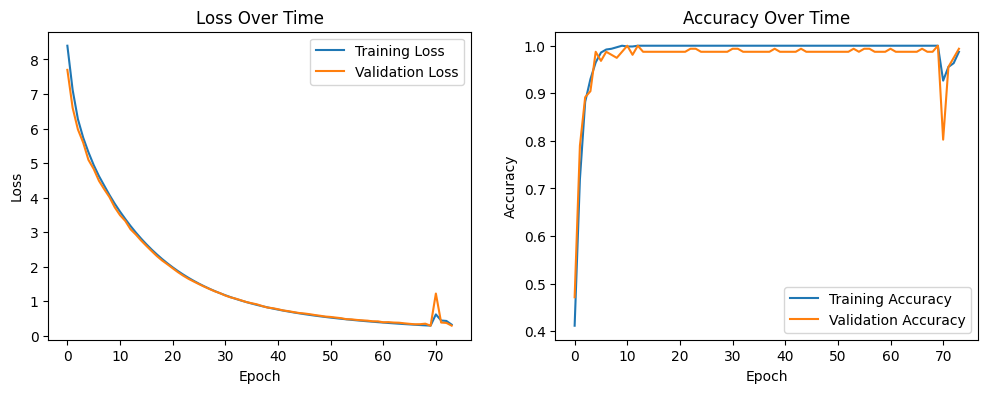

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_custom_train_loss, label='Training Loss')
plt.plot(vgg_custom_val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(vgg_custom_train_acc, label='Training Accuracy')
plt.plot(vgg_custom_val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')

plt.show()


In [22]:
vgg_custom_train_accuracy = vgg_custom_with_dropout_history.history['accuracy']
vgg_custom_val_accuracy = vgg_custom_with_dropout_history.history['val_accuracy']

print(f"Final Training Accuracy of VGG19: {vgg_custom_train_accuracy[-1]}")
print(f"Final Validation Accuracy of VGG19: {vgg_custom_val_accuracy[-1]}")

Final Training Accuracy of VGG19: 0.9872408509254456
Final Validation Accuracy of VGG19: 0.993630588054657


In [23]:
# Get model predictions
y_pred = vgg_custom_with_dropout.predict(X_test)

# Convert predictions and true labels from one-hot encoded to categorical
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred_classes))


7/7 [==============================] - 1s 74ms/step
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.82      1.00      0.90         9
           2       1.00      1.00      1.00        43
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        43
           5       0.95      1.00      0.97        19
           6       1.00      0.98      0.99        45

    accuracy                           0.98       197
   macro avg       0.97      0.98      0.97       197
weighted avg       0.99      0.98      0.99       197



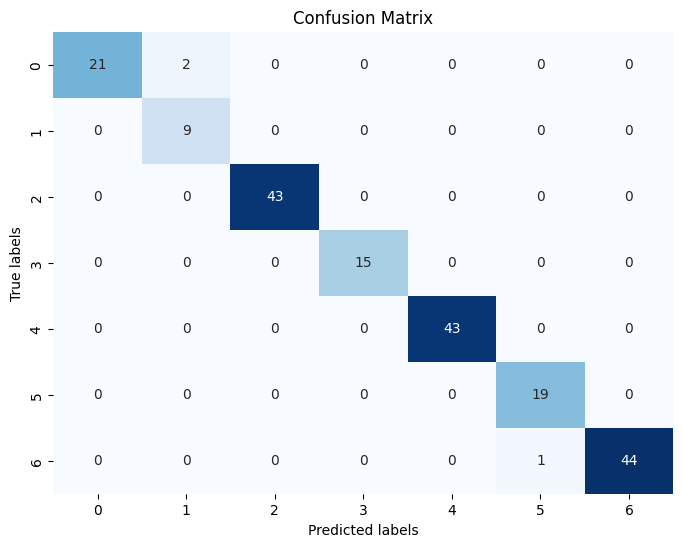

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 16ms/step


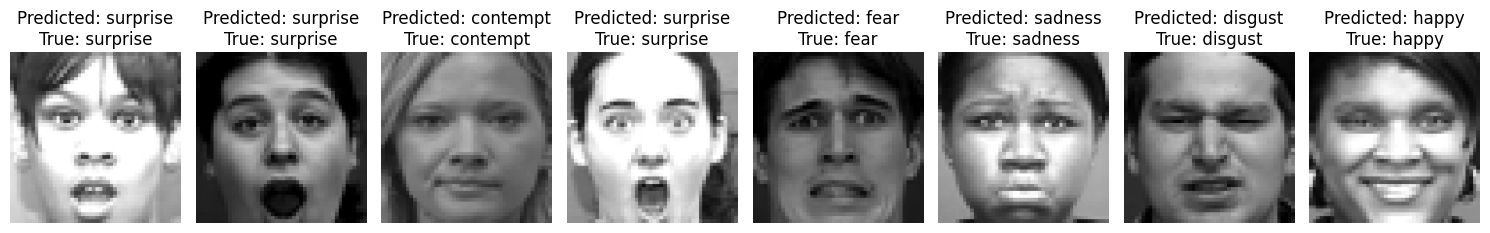

In [25]:
# Predict emotions for five images from the validation dataset
num_images_to_predict = 8

# Select five random images from the validation set
random_indices = np.random.choice(X_val.shape[0], num_images_to_predict, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]

# Make predictions using the trained model
predictions = vgg_custom_with_dropout.predict(sample_images)

# Define emotion labels based on the numerical classes
emotion_labels = {0: 'Angry', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'}

# Convert predictions and true labels to emotion labels
predicted_emotions = [emotion_labels[np.argmax(pred)] for pred in predictions]
true_emotions = [emotion_labels[np.argmax(label)] for label in sample_labels]

# Normalize the image data to the range [0, 1]
sample_images_normalized = sample_images.astype('float32') / 255.0

# Display the predicted and true labels along with the normalized images
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(15, 5))

for i in range(num_images_to_predict):
    axes[i].imshow(sample_images_normalized[i])  # Display the normalized image
    axes[i].set_title(f"Predicted: {predicted_emotions[i]}\nTrue: {true_emotions[i]}")
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


In [26]:
test_loss, test_accuracy = vgg_custom_with_dropout.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


7/7 [==============================] - 1s 70ms/step - loss: 0.3999 - accuracy: 0.9848
Test Accuracy: 0.9847715497016907


# Our Custom VGG16

In [36]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base models
vgg16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_size + (3,))


# Freeze top layers in base models
def freeze_top_layers(base_model):
     for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
        layer.trainable = False

freeze_top_layers(vgg16_base)

# for layer in vgg_base.layers:  # Freeze all layers
#         layer.trainable = False


for layer in vgg16_base.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: input_4, Trainable: False
Layer Name: block1_conv1, Trainable: False
Layer Name: block1_conv2, Trainable: False
Layer Name: block1_pool, Trainable: False
Layer Name: block2_conv1, Trainable: False
Layer Name: block2_conv2, Trainable: False
Layer Name: block2_pool, Trainable: False
Layer Name: block3_conv1, Trainable: False
Layer Name: block3_conv2, Trainable: False
Layer Name: block3_conv3, Trainable: False
Layer Name: block3_pool, Trainable: False
Layer Name: block4_conv1, Trainable: False
Layer Name: block4_conv2, Trainable: False
Layer Name: block4_conv3, Trainable: False
Layer Name: block4_pool, Trainable: False
Layer Name: block5_conv1, Trainable: True
Layer Name: block5_conv2, Trainable: True
Layer Name: block5_conv3, Trainable: True
Layer Name: block5_pool, Trainable: True


In [37]:
# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, num_classes,dropout_rate=0.1):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create transfer models with dropout
vgg16_custom_with_dropout = create_transfer_model_with_dropout(vgg16_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(vgg16_custom_with_dropout)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)


vgg16_custom_history_with_dropout = vgg16_custom_with_dropout.fit(X_train, y_train, 
                                                       batch_size= batch_size,
                                                       validation_data=(X_val, y_val),
                                                       validation_batch_size=batch_size,
                                                       epochs=epochs, 
                                                       callbacks=[early_stopping])




Epoch 1/300
20/20 [==============================] - 3s 113ms/step - loss: 8.6825 - accuracy: 0.3509 - val_loss: 7.7714 - val_accuracy: 0.5223
Epoch 2/300
20/20 [==============================] - 2s 98ms/step - loss: 7.3831 - accuracy: 0.6188 - val_loss: 6.8535 - val_accuracy: 0.7070
Epoch 3/300
20/20 [==============================] - 2s 98ms/step - loss: 6.5360 - accuracy: 0.7911 - val_loss: 6.0377 - val_accuracy: 0.9172
Epoch 4/300
20/20 [==============================] - 2s 98ms/step - loss: 5.8209 - accuracy: 0.9203 - val_loss: 5.5979 - val_accuracy: 0.9427
Epoch 5/300
20/20 [==============================] - 2s 98ms/step - loss: 5.3711 - accuracy: 0.9713 - val_loss: 5.1810 - val_accuracy: 0.9618
Epoch 6/300
20/20 [==============================] - 2s 98ms/step - loss: 5.0044 - accuracy: 0.9793 - val_loss: 4.8724 - val_accuracy: 0.9427
Epoch 7/300
20/20 [==============================] - 2s 98ms/step - loss: 4.6737 - accuracy: 0.9920 - val_loss: 4.6152 - val_accuracy: 0.9299
Epoch

In [38]:
vgg16_custom_train_loss = vgg16_custom_history_with_dropout.history['loss']
vgg16_custom_val_loss = vgg16_custom_history_with_dropout.history['val_loss']
vgg16_custom_train_acc = vgg16_custom_history_with_dropout.history['accuracy']
vgg16_custom_val_acc = vgg16_custom_history_with_dropout.history['val_accuracy']

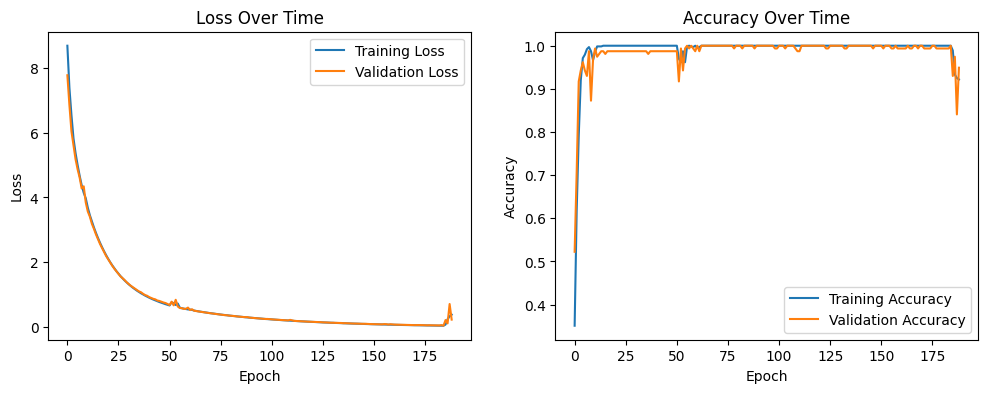

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_custom_train_loss, label='Training Loss')
plt.plot(vgg16_custom_val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(vgg16_custom_train_acc, label='Training Accuracy')
plt.plot(vgg16_custom_val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')

plt.show()


In [40]:
# Get model predictions
y_pred = vgg16_custom_with_dropout.predict(X_test)

# Convert predictions and true labels from one-hot encoded to categorical
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred_classes))


7/7 [==============================] - 0s 63ms/step
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        23
           1       0.56      1.00      0.72         9
           2       1.00      1.00      1.00        43
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00        43
           5       0.86      1.00      0.93        19
           6       1.00      0.89      0.94        45

    accuracy                           0.94       197
   macro avg       0.91      0.95      0.92       197
weighted avg       0.96      0.94      0.95       197



In [41]:
vgg16_custom_train_accuracy = vgg16_custom_history_with_dropout.history['accuracy']
vgg16_custom_val_accuracy = vgg16_custom_history_with_dropout.history['val_accuracy']

print(f"Final Training Accuracy of VGG16: {vgg16_custom_train_accuracy[-1]}")
print(f"Final Validation Accuracy of VGG16: {vgg16_custom_val_accuracy[-1]}")

Final Training Accuracy of VGG16: 0.9218500852584839
Final Validation Accuracy of VGG16: 0.9490445852279663


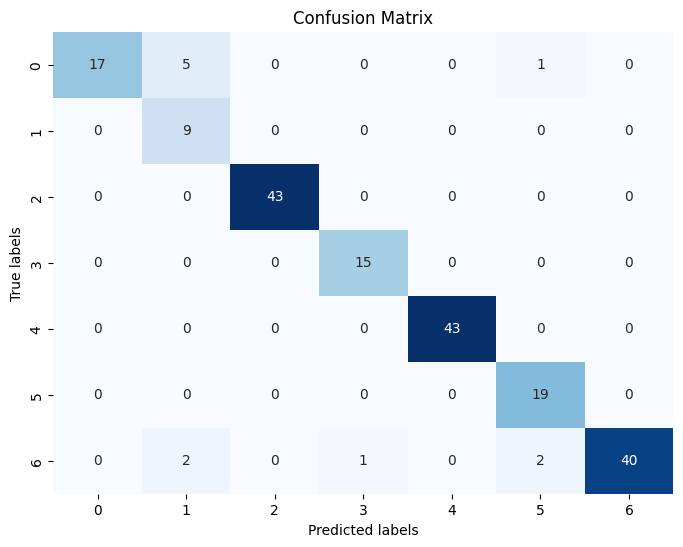

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 16ms/step


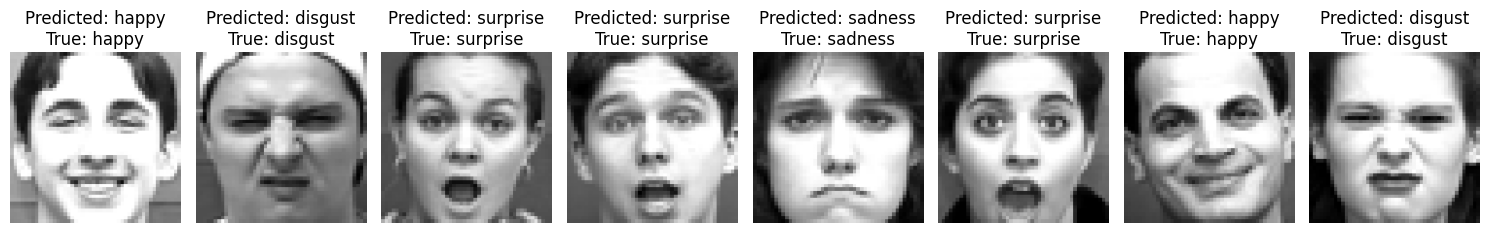

In [43]:
# Predict emotions for five images from the validation dataset
num_images_to_predict = 8

# Select five random images from the validation set
random_indices = np.random.choice(X_val.shape[0], num_images_to_predict, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]

# Make predictions using the trained model
predictions = vgg16_custom_with_dropout.predict(sample_images)

# Define emotion labels based on the numerical classes
emotion_labels = {0: 'Angry', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'}
# Convert predictions and true labels to emotion labels
predicted_emotions = [emotion_labels[np.argmax(pred)] for pred in predictions]
true_emotions = [emotion_labels[np.argmax(label)] for label in sample_labels]

# Normalize the image data to the range [0, 1]
sample_images_normalized = sample_images.astype('float32') / 255.0

# Display the predicted and true labels along with the normalized images
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(15, 5))

for i in range(num_images_to_predict):
    axes[i].imshow(sample_images_normalized[i])  # Display the normalized image
    axes[i].set_title(f"Predicted: {predicted_emotions[i]}\nTrue: {true_emotions[i]}")
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()
